In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [13]:
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [26]:
img = cv2.imread("imgs/image_369.png")

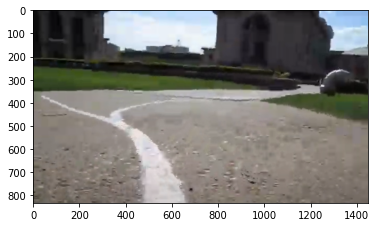

In [12]:
plt.imshow(bgr2rgb(img))
plt.show()

In [16]:
H,W,_ = img.shape
H,W

(833, 1448)

In [34]:
pts = [(H-1,0),(400,200),(400,1200),(H-1,W-1)]
for r,c in pts:
    cv2.circle(img, (c,r), radius=10, color=(0,255,0), thickness=-1)

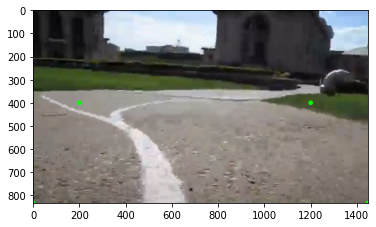

In [29]:
plt.imshow(bgr2rgb(img))
plt.show()

In [80]:
# img_name = "checkerboard/ck6.jpg"
img_name = "imgs/image_369.png"
img = bgr2rgb(cv2.imread(img_name))
H,W,_ = img.shape

In [84]:
resize=1.2
src = [(650,370), (370,370), (0,700), (1000,730)] 
src = [(int(resize*x),int(resize*y)) for x,y in src]
dst = [(10, 34), (-10, 34), (-10, 0), (10, 0)] # inches
dst = [(10*(x + 30), 10*y) for (x,y) in dst]
dst_np = np.array(dst, dtype=np.float32)
src_np = np.array(src, dtype=np.float32)
# resize,src_np, dst_np

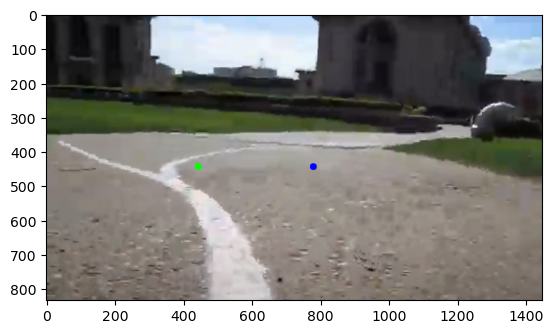

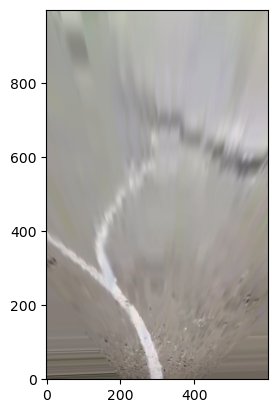

In [113]:
SCALE = 1000
colors = [
    (0, 0, 255),  # green
    (0, 255, 0),  # blue
    (255, 0, 0),  # red
    (255, 255, 0),  # yellow
]
for cnr_idx, (x, y) in enumerate(src):
    cv2.circle(img, (x, y), 10, colors[cnr_idx], -1)
plt.imshow(img)
plt.show()

img = bgr2rgb(cv2.imread(img_name))

M = cv2.getPerspectiveTransform(src_np, dst_np)
h, w = img.shape[:2]
warped = cv2.warpPerspective(img, M, (600, 1000), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
plt.imshow(warped, origin='lower')
plt.show()

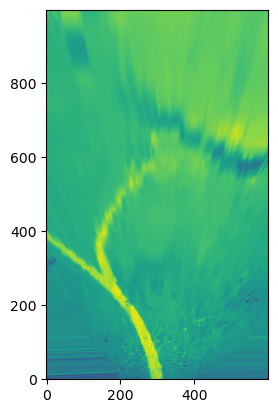

In [114]:
yuv = cv2.cvtColor(warped, cv2.COLOR_RGB2YUV)
plt.imshow(yuv[:,:,0], origin='lower')
plt.show()
yuv = yuv[:,:,0]

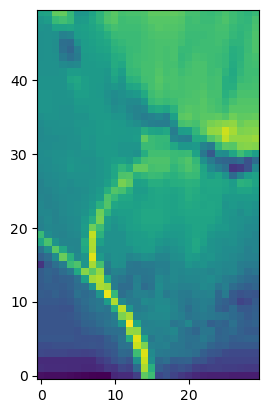

In [115]:
shape = (yuv.shape[1] // 20, yuv.shape[0] // 20)
resized = cv2.resize(yuv, shape, interpolation = cv2.INTER_AREA)
plt.imshow(resized, origin='lower')
plt.show()

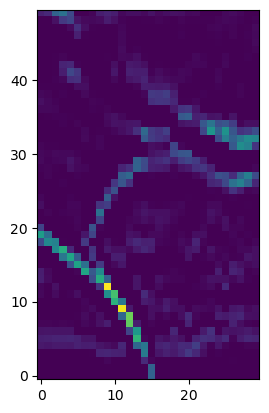

In [116]:
tophat = np.array([-1, -1, 2, 2, -1, -1])
conv = cv2.filter2D(src=resized, ddepth=-1, kernel=tophat)
plt.imshow(conv, origin='lower')
plt.show()

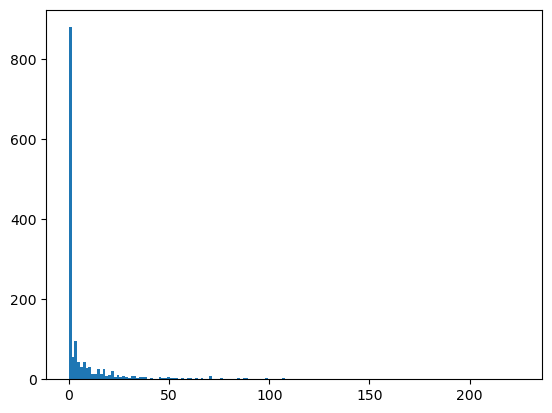

In [132]:
# hist, bin_edges = np.histogram(conv.flatten())
plt.hist(conv.flatten(), bins='auto')
plt.show()

In [134]:
avg = np.mean(conv)
avg

9.34

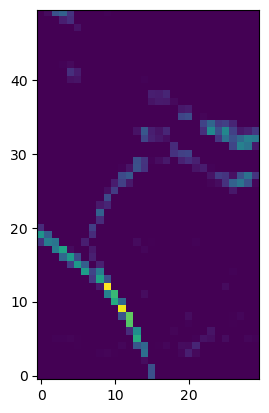

In [161]:
avg = 20
diff = conv.astype(np.float32) - avg
relud = (diff * (diff > 0)) + avg
plt.imshow(relud, origin='lower')
plt.show()

In [155]:
cv2.fitLine(relud, distType=cv2.DIST_L2)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'fitLine'
> Overload resolution failed:
>  - fitLine() missing required argument 'param' (pos 3)
>  - fitLine() missing required argument 'param' (pos 3)


In [68]:
# from time import sleep
# from picamera import PiCamera

# camera = PiCamera()
# camera.resolution = [1024, 768]
# camera.start_preview()

# sleep(2)

# camera.capture('foo.jpg')
# camera.close()

In [11]:
import cv2
import numpy as np
import os
import glob
CHECKERBOARD = (6,9)
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('checkerboard/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

Found 3 valid images for calibration
DIM=(1024, 768)
K=np.array([[465.2204776706876, 0.0, 520.6063573966712], [0.0, 464.00154309364046, 327.28279417219517], [0.0, 0.0, 1.0]])
D=np.array([[0.10872294377145097], [1.162022223507608], [-7.00997452733623], [8.771499066792968]])


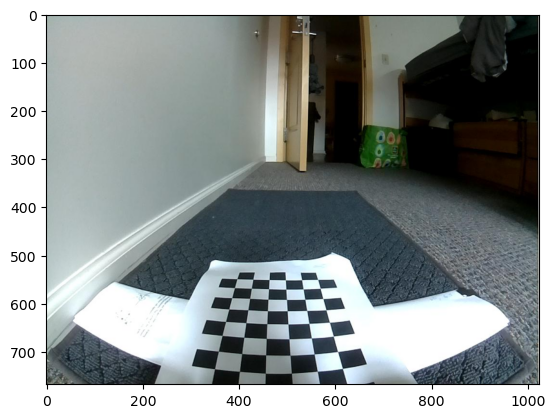

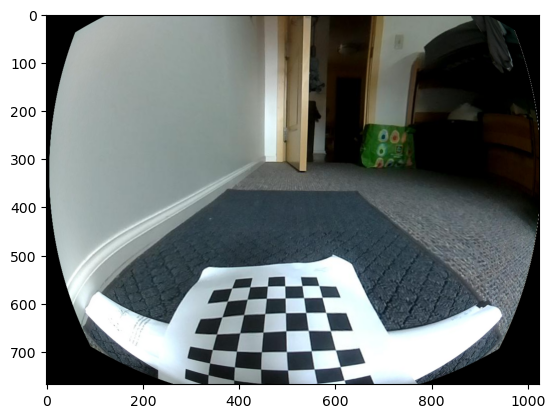

In [66]:
# You should replace these 3 lines with the output in calibration step
DIM=(1024, 768)
K=np.array([[465.2204776706876, 0.0, 520.6063573966712], [0.0, 464.00154309364046, 327.28279417219517], [0.0, 0.0, 1.0]])
K_new = np.array([[465.2204776706876, 0.0, 520.6063573966712], [0.0, 464.00154309364046, 327.28279417219517], [0.0, 0.0, 1.0]])

D=np.array([[0.10872294377145097], [1.162022223507608], [-7.00997452733623], [8.771499066792968]])
def undistort(img_path):
    plt.imshow(bgr2rgb(cv2.imread(img_path)))
    plt.show()
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K_new, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    plt.imshow(bgr2rgb(undistorted_img))
    plt.show()

undistort('checkerboard/ck1.jpg')